In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from dep_tools.grids import PACIFIC_EPSG
from fiona.io import ZipMemoryFile
from odc.geo.geom import Geometry
from odc.geo.xr import mask
from odc.stac import load
from pystac.client import Client
from xarray import DataArray, Dataset

In [2]:
site = "Kikori_2" 

In [3]:
aoi = gpd.read_file("priority_1_sites/subsample_sites/"f"{site}.geojson")

In [4]:
bbox = aoi.to_crs("EPSG:4326")

In [5]:
bounds_df = bbox.bounds
bounds_df

,minx,miny,maxx,maxy
0,144.392223,-7.659098,144.680461,-7.580679


In [6]:
values_array = bounds_df.values
flat_array = values_array.flatten()
bbox_int_list = flat_array.tolist()
bbox_tuple = tuple(bbox_int_list)

In [7]:
bbox = Geometry(bbox.geometry.values[0], crs=bbox.crs)

In [8]:
# bbox.explore()

In [9]:
# Get some seagrass data for the area
client = Client.open("https://stac.digitalearthpacific.org")
items = client.search(
    collections=["dep_s2_ammi"],
    intersects=bbox.json
).item_collection()

print(f"Found {len(items)} items")

Found 16 items


In [10]:
data = load(
    items,
    bbox=bbox_tuple,
    bands=["mangroves"],
    crs=PACIFIC_EPSG,  # 
    resolution=10,  # Change to 10 for full resolution,
    chunks={"x": 2048, "y": 2048}
)

# Convert data to 0 and 1, where 

data = data.mangroves != 255

data

<xarray.DataArray 'mangroves' (time: 8, y: 876, x: 3210)> Size: 22MB
dask.array<ne, shape=(8, 876, 3210), dtype=bool, chunksize=(1, 876, 2048), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 7kB -8.407e+05 -8.407e+05 ... -8.495e+05 -8.495e+05
  * x            (x) float64 26kB -6.243e+05 -6.242e+05 ... -5.922e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 64B 2017-01-01 2018-01-01 ... 2024-01-01

In [11]:
def xarray_calculate_area(
    data: Dataset | DataArray,
    geom: Geometry,
    variable: str | None = None,
    value: int | float | None = None,
) -> float:
    # Work with a dataarray, not a dataset, so it's a singular thing
    if type(data) is not DataArray:
        if variable is None:
            raise ValueError("Variable must be specified when data is a Dataset.")
        data = data[variable]

    # Only select a specific value. This will convert to float, with nans
    if value is not None:
        data = data.where(data == value)

    # Mask out regions outsize the geometry
    masked = mask(data, geom.to_crs(data.odc.crs))

    # Count all the non-nan cells, and multiply by area
    count = float(masked.notnull().sum().values)
    one_pixel_area = abs(
        masked.odc.geobox.resolution.x * masked.odc.geobox.resolution.y
    )

    return float(count) * one_pixel_area

In [12]:
bbox.explore()

In [33]:
# Run the xarray_calculate_area per time step
results = []
for time in data.time:
    da = data.sel(time=time)
    area_m2 = xarray_calculate_area(da, bbox, variable="mangroves", value=1)
    # Year, in YYYY, area in m2, area in km2
    results.append({
        "time": pd.to_datetime(time.values).year,
        # "area_m2": area_m2,
        "ammi_ha": area_m2 / 10000
    })

df = pd.DataFrame(results)
# df

In [34]:
# Keep only the rows where year is NOT 2017
df = df[df['time'] != 2017]

# Reset the index so it starts at 0, 1, 2... again
df = df.reset_index(drop=True)

df

,time,ammi_ha
0,2018,10150.94
1,2019,6697.47
2,2020,5343.70
3,2021,5998.03
4,2022,8474.32
5,2023,10885.17
6,2024,9404.70


<Axes: xlabel='time'>

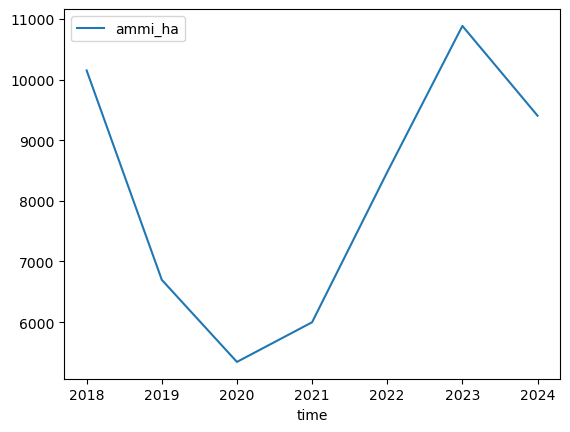

In [35]:
df = df.set_index('time')
df.plot.line()

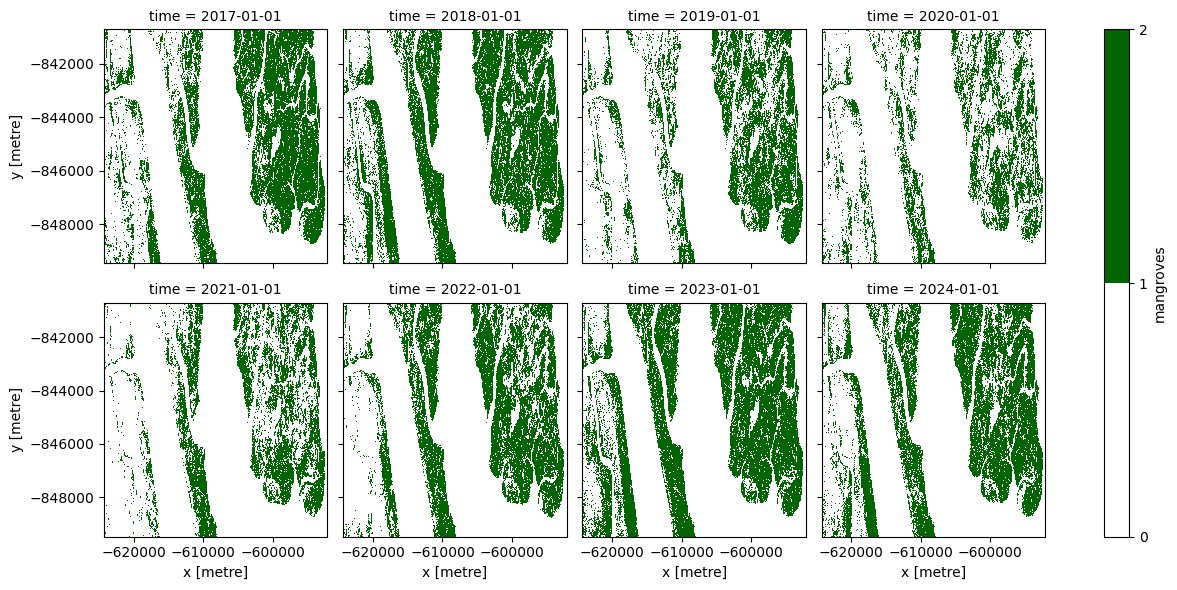

In [15]:
data.plot.imshow(
    col="time",
    col_wrap=4,
    levels=[0, 1, 2],
    colors=["white", "darkgreen"],
)

In [16]:
mangroves_2018 = data.isel(time=1)
mangroves_2018 = mangroves_2018.astype("uint16")
mangroves_2024 = data.isel(time=7)
mangroves_2024 = mangroves_2024.astype("uint16")
mangrove_change_2018_2024 = (mangroves_2024*-2) - mangroves_2018
# mangrove_change_2018_2024.odc.write_cog("change_detection/mangroves_ammi_change_"f"{site}_2018_2024.tiff")

In [17]:
# area_df = df.set_index('time')
# transposed_df = df.transpose()
# transposed_df.index.name = None
# transposed_df

In [18]:
# df = transposed_df
# df.columns.name = None
# df.columns = df.columns.astype(int)
# df.index.name = None
# df

In [21]:
# Keep everything from row 1 onwards
# for rows
# df = df.iloc[1:]
## for columns 
# df = df.iloc[:, 1:]
# Optional: Reset index again to start at 0
df = df.reset_index(drop=True)

df

,ammi_ha
0,10150.94
1,6697.47
2,5343.70
3,5998.03
4,8474.32
5,10885.17
6,9404.70


In [20]:
df_clean

NameError: name 'df_clean' is not defined

In [ ]:
df_clean = df.set_index('time')
df_clean.plot.line()

In [ ]:
df_clean.to_csv("change_detection/"f"{site}.csv")

In [ ]:
# df.plot(x="ammi_ha", y="ammi_ha", marker="o", title=site, ylim=(0, df["ammi_ha"].max() * 1.1))

In [ ]:
# for r in results:
#     print(f"{r['time']}: {r['ammi_ha']:.2f} km²")

In [ ]:
# df

In [ ]:
# mangrove_change_2018_2024 = data.mangrove.isel(time=7) - data.mangrove.isel(time=1)